# TensorFlow: Optimization & Training (Expert)

https://www.tensorflow.org/  
공식 홈페이지에서 설명하는 Expert 버젼을 배워보자

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

# Build Model

In [2]:
input_shape = (28, 28, 1)
num_classes = 10

In [3]:
inputs = layers.Input(input_shape, dtype=tf.float64)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.5)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

# Preprocess

텐서플로우 공식홈페이지에서 말한 expert한 방법
- tf.data 사용

In [4]:
mnist = tf.keras.datasets.mnist

# Load Data from MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Channel 차원 추가
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Data Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0

- from_tensor_slices()
- shuffle()
- batch()

## tf.data

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(32)

### Visualize Data

matplotlib 불러와서 데이터 시각화하기

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

train_ds.take()

In [7]:
(32, 28, 28, 1)

(32, 28, 28, 1)

In [8]:
image, label = next(iter(train_ds))

In [9]:
image.shape, label.shape

(TensorShape([32, 28, 28, 1]), TensorShape([32]))

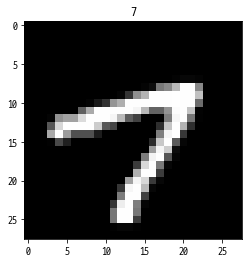

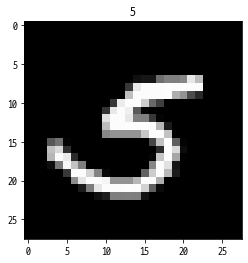

In [10]:
for image, label in train_ds.take(2):
    plt.title(label.numpy()[0])
    plt.imshow(image[0, :, :, 0], 'gray')
    plt.show()

# Training (Keras)

Keras로 학습 할 때는 기존과 같지만, train_ds는 generator라서 그대로 넣을 수 있음

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(train_ds, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 99s 53ms/step - loss: 0.0500
Epoch 2/5
1875/1875 [==============================] - 98s 52ms/step - loss: 0.0458
Epoch 3/5
1875/1875 [==============================] - 107s 57ms/step - loss: 0.0440
Epoch 4/5
1875/1875 [==============================] - 104s 55ms/step - loss: 0.0396
Epoch 5/5
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0368


# Optimization  

- Loss Function
- Optimizer

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

- Loss Function를 담을 곳
- Metrics

In [14]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training  

@tf.function - 기존 session 열었던 것처럼 바로 작동 안 하고, 그래프만 만들고 학습이 시작되면 돌아가도록 함

In [15]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [16]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [17]:
for epoch in range(2):
    print('Start Training')
    for images, labels in train_ds:
        train_step(images, labels)
        
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss {}, Test Accuracy: {}'
    print(template.format(epoch+1, 
                          train_loss.result(),
                          train_accuracy.result() * 100, 
                          test_loss.result(), 
                          test_accuracy.result() * 100)) 

Start Training
Epoch 1, Loss: 0.017522336915135384, Accuracy: 99.461669921875, Test Loss 0.030189935117959976, Test Accuracy: 99.1199951171875
Start Training
Epoch 2, Loss: 0.014562921598553658, Accuracy: 99.54083251953125, Test Loss 0.02812238410115242, Test Accuracy: 99.1550064086914
